In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb
import ast
from scipy import stats

In [3]:
import torch
from torch_geometric.data import Data, DataLoader

In [4]:
cwd = os.getcwd()
print(cwd)

/cluster/home/skyriakos/chemprop_run/git/notebooks


In [5]:
pd.set_option('display.max_rows', 100)

In [6]:
os.chdir('..')
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
from deepadr.model_gnn import GCN as testGCN
os.chdir(cwd)

In [7]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [8]:
# from tdc.single_pred import Tox
# from tdc.multi_pred import DDI
from tdc.multi_pred import DrugSyn
# data = DrugSyn(name = 'OncoPolyPharmacology')



In [9]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [10]:
report_available_cuda_devices()

number of GPUs available: 8
cuda:0, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:1, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:2, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:3, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:4, name:GeForce GTX 1080 Ti
total memory av

In [11]:
n_gpu = torch.cuda.device_count()
n_gpu

8

In [12]:
fdtype = torch.float32

In [13]:
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)

torch: 1.9.1
CUDA: 11.1


### Preparing dataset 

In [14]:
score = 'zip_thresh'
score_val = 1

In [15]:
# TDC Tox
DSdataset_name = f'DrugComb_{score}_{score_val}' #'DrugComb'
# OncoPolyPharmacology is the MERCK dataset


#fname_suffix = ds_config["fname_suffix"]
similarity_types = ['chem']
kernel_option = 'sqeuclidean'
data_fname = 'data_v1'
# interact_matfname = ds_config["interact_matfname"]
# exp_iden = 'simtypeall'
# ddi_interaction_labels_pth = ds_config["ddi_interaction_labels_pth"]

# up_dir, processed_dir, DSdataset_name, data_fname

In [16]:
df_drugcomb = pd.read_csv(f'../data/drugcomb/v1_5__17_02_2022/processed_datasets/drugcomb_{score}_{score_val}.csv')
df_drugcomb

,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,dacarbazine,717906-29-1,A-673,684052,CN(C)N=NC1=C(NC=N1)C(=O)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,CHEMBL3348974,717906-29-1,A-673,684052,CC(C)OC(=O)C(C)NP(=O)(OCC1C(C(C(O1)N2C=CC(=O)N...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
2,Nesbuvir,717906-29-1,A-673,684052,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
3,BMS-599626,717906-29-1,A-673,684052,CC1=C2C(=NC=NN2C=C1NC(=O)OCC3COCCN3)NC4=CC5=C(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
4,WZ8040,717906-29-1,A-673,684052,CN1CCN(CC1)C2=CC=C(C=C2)NC3=NC=C(C(=N3)SC4=CC=...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
...,...,...,...,...,...,...,...
88973,Vorinostat,KU-60019,VM-CUB-1,909780,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,CC1CN(CC(O1)C)CC(=O)NC2=CC3=C(C=C2)SC4=C(C=CC=...,1
88974,AZD5582,AZD4320,VM-CUB-1,909780,CC(C(=O)NC(C1CCCCC1)C(=O)N2CCCC2C(=O)NC3C(CC4=...,CN(CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O)N...,0
88975,957054-30-7,Sapitinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,1
88976,957054-30-7,Selumetinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,1


In [17]:
df_rma_landm = pd.read_csv('../data/synergxdb/RMA/df_rma_landm.tsv', sep="\t")
df_rma_landm

,Unnamed: 0,GENE_SYMBOLS,GENE_title,DATA.906826,DATA.687983,DATA.910927,DATA.1240138,DATA.1240139,DATA.906792,DATA.910688,...,DATA.753584,DATA.907044,DATA.998184,DATA.908145,DATA.1659787,DATA.1298157,DATA.1480372,DATA.1298533,DATA.930299,DATA.905954.1
0,0,TSPAN6,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],7.632023,7.548671,8.712338,7.797142,7.729268,7.074533,3.285198,...,7.105637,3.236503,3.038892,8.373223,6.932178,8.441628,8.422922,8.089255,3.112333,7.153127
1,3,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...,3.614794,4.066887,3.956230,4.063701,4.341500,4.270903,5.968168,...,3.696835,4.624013,4.348524,3.858121,3.947561,4.425849,3.550390,4.443337,4.266828,4.100493
2,19,BAD,BCL2-associated agonist of cell death [Source:...,7.458409,7.479327,7.419672,7.731137,6.998981,6.550210,6.354063,...,7.147962,6.478426,6.919537,6.801096,7.153122,7.234464,7.525257,6.066356,8.185968,4.967268
3,20,LAP3,leucine aminopeptidase 3 [Source:HGNC Symbol;A...,6.453926,6.742826,5.655691,5.259367,4.611395,6.930777,8.560707,...,5.383810,8.591164,6.208059,6.715130,6.530806,5.759933,7.810126,7.182077,5.663629,6.539451
4,28,SNX11,sorting nexin 11 [Source:HGNC Symbol;Acc:14975],4.767457,5.246301,4.645800,4.558836,5.456692,5.099542,7.574348,...,4.755084,6.761799,5.034195,4.958603,4.629068,4.982202,5.037259,4.611973,4.800284,4.967207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,17083,PLEKHM1,"pleckstrin homology domain containing, family ...",6.167946,5.271099,5.784561,7.587263,6.479184,5.700915,6.617353,...,6.714959,6.368537,8.252268,6.436644,6.436742,5.551436,5.634834,7.083564,5.776658,6.306988
904,17400,MIF,macrophage migration inhibitory factor (glycos...,11.893872,11.841300,12.272137,12.000410,11.867211,12.621575,11.825283,...,12.286071,12.572595,12.254136,12.588238,12.366026,12.153612,12.265099,11.919307,12.762295,12.985613
905,17444,PRAF2,"PRA1 domain family, member 2 [Source:HGNC Symb...",5.060852,6.515567,4.815762,4.544863,6.071288,4.777850,3.455981,...,5.314914,2.943601,4.723601,5.769965,5.070665,3.443244,3.293080,2.978125,5.125786,4.404205
906,17575,LYN,v-yes-1 Yamaguchi sarcoma viral related oncoge...,5.892532,4.580184,6.482469,7.094195,7.932918,7.333405,10.455397,...,4.914232,9.453552,3.218797,4.073831,6.355383,8.348965,7.579339,4.456322,5.857488,3.013612


In [18]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
# ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))

path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr


In [19]:
targetdata_dir

'/cluster/home/skyriakos/chemprop_run/git/data/processed/DrugComb_zip_thresh_1/data_v1'

In [20]:
# data = DDI(name = DSdataset_name).get_data(format = 'df')
# data = DrugSyn(name = DSdataset_name).get_data(format = 'df')


In [21]:
# from tdc.utils import get_label_map
# get_label_map(name = 'DrugBank', task = 'DDI')


In [22]:
# data = Tox(name = DSdataset_name).get_data(format = 'df')
# smiles, labels = data['Drug'], data['Y']

In [23]:
data = df_drugcomb
data

,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,dacarbazine,717906-29-1,A-673,684052,CN(C)N=NC1=C(NC=N1)C(=O)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,CHEMBL3348974,717906-29-1,A-673,684052,CC(C)OC(=O)C(C)NP(=O)(OCC1C(C(C(O1)N2C=CC(=O)N...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
2,Nesbuvir,717906-29-1,A-673,684052,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
3,BMS-599626,717906-29-1,A-673,684052,CC1=C2C(=NC=NN2C=C1NC(=O)OCC3COCCN3)NC4=CC5=C(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
4,WZ8040,717906-29-1,A-673,684052,CN1CCN(CC1)C2=CC=C(C=C2)NC3=NC=C(C(=N3)SC4=CC=...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
...,...,...,...,...,...,...,...
88973,Vorinostat,KU-60019,VM-CUB-1,909780,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,CC1CN(CC(O1)C)CC(=O)NC2=CC3=C(C=C2)SC4=C(C=CC=...,1
88974,AZD5582,AZD4320,VM-CUB-1,909780,CC(C(=O)NC(C1CCCCC1)C(=O)N2CCCC2C(=O)NC3C(CC4=...,CN(CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O)N...,0
88975,957054-30-7,Sapitinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,1
88976,957054-30-7,Selumetinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,1


In [24]:
data

,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,dacarbazine,717906-29-1,A-673,684052,CN(C)N=NC1=C(NC=N1)C(=O)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,CHEMBL3348974,717906-29-1,A-673,684052,CC(C)OC(=O)C(C)NP(=O)(OCC1C(C(C(O1)N2C=CC(=O)N...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
2,Nesbuvir,717906-29-1,A-673,684052,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
3,BMS-599626,717906-29-1,A-673,684052,CC1=C2C(=NC=NN2C=C1NC(=O)OCC3COCCN3)NC4=CC5=C(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
4,WZ8040,717906-29-1,A-673,684052,CN1CCN(CC1)C2=CC=C(C=C2)NC3=NC=C(C(=N3)SC4=CC=...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
...,...,...,...,...,...,...,...
88973,Vorinostat,KU-60019,VM-CUB-1,909780,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,CC1CN(CC(O1)C)CC(=O)NC2=CC3=C(C=C2)SC4=C(C=CC=...,1
88974,AZD5582,AZD4320,VM-CUB-1,909780,CC(C(=O)NC(C1CCCCC1)C(=O)N2CCCC2C(=O)NC3C(CC4=...,CN(CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O)N...,0
88975,957054-30-7,Sapitinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,1
88976,957054-30-7,Selumetinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,1


In [25]:
data[(data.Drug1.str.contains("1742"))]

,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y


In [26]:
data = data.drop(index=data[(data.Drug1.str.contains("Antibody")) | (data.Drug2.str.contains("Antibody"))].index)
data.index = range(len(data))
len(data)

88944

In [27]:
# datashort = data[['Drug1_ID', 'Drug2_ID', 'Y']]
# datashort.Y = 1
# datashort = datashort[~datashort.duplicated()]
# datashort

In [28]:
uniq_data = ddi_dataframe_to_unique_drugs(data)
uniq_data

,Drug_ID,Drug
0,dacarbazine,CN(C)N=NC1=C(NC=N1)C(=O)N
1,CHEMBL3348974,CC(C)OC(=O)C(C)NP(=O)(OCC1C(C(C(O1)N2C=CC(=O)N...
2,Nesbuvir,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...
3,BMS-599626,CC1=C2C(=NC=NN2C=C1NC(=O)OCC3COCCN3)NC4=CC5=C(...
4,WZ8040,CN1CCN(CC1)C2=CC=C(C=C2)NC3=NC=C(C(=N3)SC4=CC=...
...,...,...
1805,SCHEMBL1557791,CC1=NN(C=C1NC2=NC=C(C(=C2)NC3=CC=CC=C3C(=O)NC)...
1806,homoharringtonine,CC(C)(CCCC(CC(=O)OC)(C(=O)OC1C2C3=CC4=C(C=C3CC...
1807,NSC169534,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...
1808,LSM-4270,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...


In [29]:
uniq_data.Drug = [d.split("; ")[1] if ("; " in d) else d for d in uniq_data.Drug]
uniq_data.Drug = [d.split(";")[1] if (";" in d) else d for d in uniq_data.Drug]

In [30]:
uniq_data['Mol'] = [smiles_to_mol(smiles) for smiles in uniq_data.Drug]

In [31]:
uniq_mol = uniq_data[~uniq_data.Mol.isnull()]
# uniq_mol['Data'] = [mol_to_graph_data_obj_simple(mol) for mol in uniq_mol.Mol]
uniq_mol['DataOGB'] = [smiles_to_graph_data_obj_ogb(smiles) for smiles in uniq_mol.Drug]
uniq_mol = uniq_mol.set_index("Drug_ID")
uniq_mol

,Drug,Mol,DataOGB
Drug_ID,,,
dacarbazine,CN(C)N=NC1=C(NC=N1)C(=O)N,<rdkit.Chem.rdchem.Mol object at 0x2ab3d081df40>,"[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,..."
CHEMBL3348974,CC(C)OC(=O)C(C)NP(=O)(OCC1C(C(C(O1)N2C=CC(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x2ab3d081d7c0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,..."
Nesbuvir,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,<rdkit.Chem.rdchem.Mol object at 0x2ab3d0bd9460>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
BMS-599626,CC1=C2C(=NC=NN2C=C1NC(=O)OCC3COCCN3)NC4=CC5=C(...,<rdkit.Chem.rdchem.Mol object at 0x2ab3d0bd9940>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
WZ8040,CN1CCN(CC1)C2=CC=C(C=C2)NC3=NC=C(C(=N3)SC4=CC=...,<rdkit.Chem.rdchem.Mol object at 0x2ab3d074b640>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
...,...,...,...
SCHEMBL1557791,CC1=NN(C=C1NC2=NC=C(C(=C2)NC3=CC=CC=C3C(=O)NC)...,<rdkit.Chem.rdchem.Mol object at 0x2ab3d0fafe20>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
homoharringtonine,CC(C)(CCCC(CC(=O)OC)(C(=O)OC1C2C3=CC4=C(C=C3CC...,<rdkit.Chem.rdchem.Mol object at 0x2ab3d0fafe80>,"[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,..."
NSC169534,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...,<rdkit.Chem.rdchem.Mol object at 0x2ab3d0fafee0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."


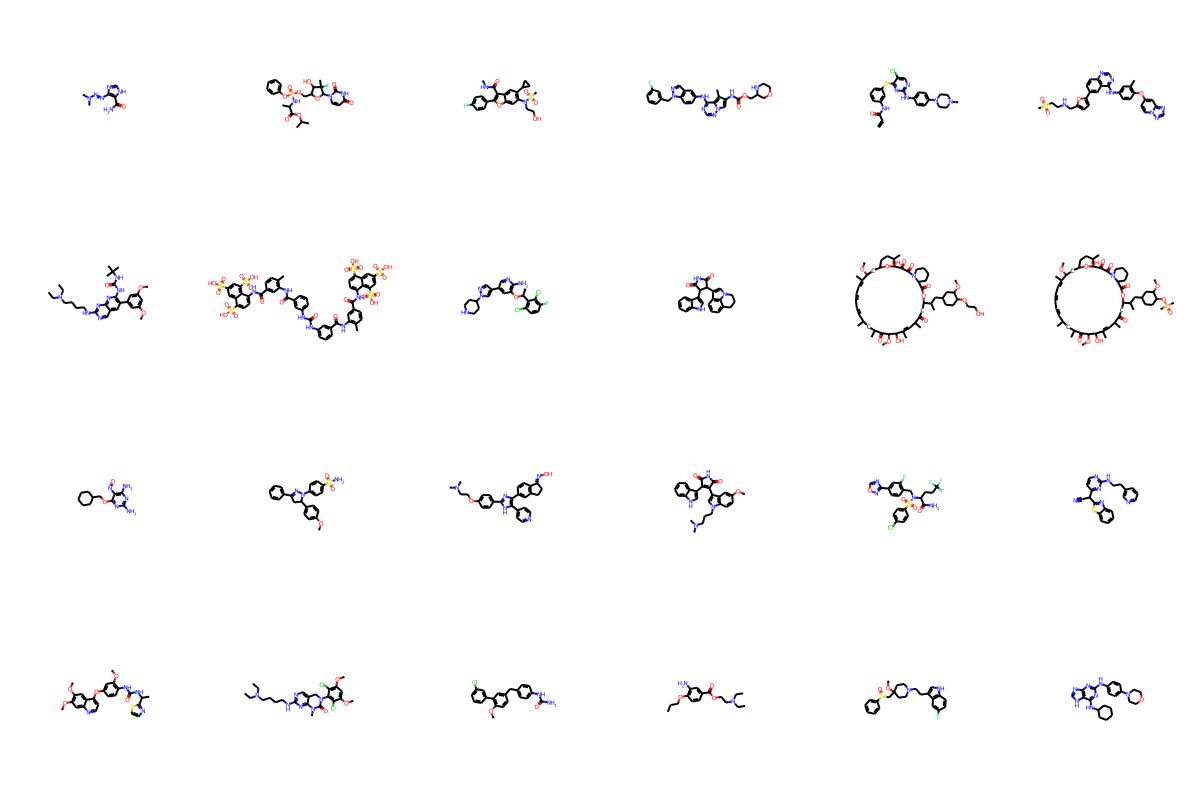

In [32]:
Draw.MolsToGridImage(uniq_mol.Mol.head(24), molsPerRow=6)

In [33]:
# num_drugs = len(uniq_mol)
# int((num_drugs * (num_drugs-1))/2)

In [34]:
# uniq_mol.iloc[0].Data

In [35]:
uniq_mol.iloc[0].DataOGB

Data(edge_index=[2, 26], edge_attr=[26, 3], x=[13, 9])

In [36]:
# zhang_labels = pd.read_csv(rawdata_dir + '/DS1/drug_drug_matrix_wids.csv').set_index('Unnamed: 0')
# y_df = zhang_labels

In [37]:
# %%time

# y_df = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'y_df.pkl'),
#                                      data_gen_fun = generate_labels_df,
#                                      data_gen_params=(uniq_mol, datashort))

In [38]:
# y_df = generate_labels_df(uniq_mol, data)

# ReaderWriter.dump_data(y_df, os.path.join(targetdata_dir_raw, 'y_df.pkl'))

#y_df = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'y_df.pkl'))

In [39]:
# y_df

In [40]:
# y_df[y_df > 0] = 1
# y_df

In [41]:
# y = get_y_from_interactionmat(y_df.to_numpy())
# len(y)

In [42]:
# binary_Y_threshold = 30

In [43]:
y = data.Y.copy()
y

0        0
1        1
2        0
3        1
4        1
        ..
88939    1
88940    0
88941    1
88942    1
88943    0
Name: Y, Length: 88944, dtype: int64

In [44]:
# str(round((len(y[y>=binary_Y_threshold]) / len(y) *100), 2)) + "% positive labels"

In [45]:
# sns.boxplot(y)

In [46]:
# positive_labels = y>=binary_Y_threshold
# negative_labels = y<binary_Y_threshold

In [47]:
# y[positive_labels] = 1
# y[negative_labels] = 0
# y = y.astype(int)
# y

In [48]:
y.value_counts()

1    47146
0    41798
Name: Y, dtype: int64

In [49]:
ReaderWriter.dump_data(y.values, os.path.join(targetdata_dir_raw, 'y.pkl'))

In [50]:
y_weights = compute_class_weights(torch.tensor(y))
y_weights

array([1.06397435, 0.94328257])

In [51]:
ReaderWriter.dump_data(y_weights, os.path.join(targetdata_dir_raw, 'y_weights.pkl'))

In [52]:
expression = np.array([df_rma_landm['DATA.'+ str(c)].values for c in data["Cosmic_ID"]])
expression.shape

(88944, 908)

In [53]:
ReaderWriter.dump_data(expression, os.path.join(targetdata_dir_raw, 'expression.pkl'))

In [54]:
# report_label_distrib(y)

In [55]:
# lasso_input_dim = 2*tp["emb_dim"]+1+expression_input_size
# lasso_out_dim = dataset.num_classes

# lassonet_model = LassoNet(lasso_input_dim, lasso_out_dim)# # pairs = list(itertools.combinations(uniq_mol.Drug_ID, 2))
# pairs = construct_sampleid_ddipairs(y_df.to_numpy())
# len(pairs)

In [56]:
pairs = {i:(row.Drug1_ID, row.Drug2_ID) for i, row in data.iterrows()}
len(pairs)

88944

In [57]:
pairs

{0: ('dacarbazine', '717906-29-1'),
 1: ('CHEMBL3348974', '717906-29-1'),
 2: ('Nesbuvir', '717906-29-1'),
 3: ('BMS-599626', '717906-29-1'),
 4: ('WZ8040', '717906-29-1'),
 5: ('Arry-380', '717906-29-1'),
 6: ('219580-11-7', '717906-29-1'),
 7: ('suramin', '717906-29-1'),
 8: ('Crizotinib', '717906-29-1'),
 9: ('SCHEMBL224883', '717906-29-1'),
 10: ('CHEMBL3348822', '717906-29-1'),
 11: ('NCGC00346481-01', '717906-29-1'),
 12: ('NU6027', '717906-29-1'),
 13: ('ML141', '717906-29-1'),
 14: ('405554-55-4', '717906-29-1'),
 15: ('go 6983', '717906-29-1'),
 16: ('Avagacestat', '717906-29-1'),
 17: ('AS601245', '717906-29-1'),
 18: ('Ki20227', '717906-29-1'),
 19: ('SCHEMBL17378613', '717906-29-1'),
 20: ('1155877-97-6', '717906-29-1'),
 21: ('proparacaine', '717906-29-1'),
 22: ('CHEMBL166161', '717906-29-1'),
 23: ('Reversine', '717906-29-1'),
 24: ('1262770-73-9', '717906-29-1'),
 25: ('CHEMBL39740', '717906-29-1'),
 26: ('176977-56-3', '717906-29-1'),
 27: ('etodolac', '717906-29-1'),


In [58]:
# pairs_sub = {k: pairs[k] for k in range(10)}
# pairs_sub

In [59]:
uniq_mol.loc['ZINC34894448']

Drug       CCC1=C2N=C(C=C(N2N=C1)NCC3=C[N+](=CC=C3)[O-])N...
Mol         <rdkit.Chem.rdchem.Mol object at 0x2ab3d0f873a0>
DataOGB    [(edge_index, [tensor([ 0,  1,  1,  2,  2,  3,...
Name: ZINC34894448, dtype: object

In [60]:
%%time

X = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'X.pkl'),
                              data_gen_fun=get_X_all_pairdata_synergy,
                              data_gen_params=(uniq_mol, pairs, "DataOGB"))

CPU times: user 14.3 s, sys: 132 ms, total: 14.4 s
Wall time: 14.4 s


In [61]:
# X = get_X_all_pairdata(uniq_mol, pairs)

# ReaderWriter.dump_data(X, os.path.join(targetdata_dir_raw, 'X.pkl'))

#X = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'X.pkl'))


In [62]:
# X

In [63]:
targetdata_dir

'/cluster/home/skyriakos/chemprop_run/git/data/processed/DrugComb_zip_thresh_1/data_v1'

In [64]:
targetdata_dir_processed

'/cluster/home/skyriakos/chemprop_run/git/data/processed/DrugComb_zip_thresh_1/data_v1/processed'

In [65]:
# import glob

# list_generated_files = glob.glob(targetdata_dir_processed + "/*")
# print(list_generated_files)

# for file in list_generated_files:
#     os.remove(file)

In [66]:
%%time

# In order to generate a new Dataset, first remove the generated files above

dataset = MoleculeDataset(root=targetdata_dir, dataset='tdcSynergy')

Processing...
Done!


CPU times: user 8.4 s, sys: 2.78 s, total: 11.2 s
Wall time: 11.6 s


In [67]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data0 = dataset[0]  # Get the first graph object.

# print()
# print(data)
# print('=============================================================')

# # Gather some statistics about the first graph.
# print(f'Number of nodes: {data.num_nodes}')
# print(f'Number of edges: {data.num_edges}')
# print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
# print(f'Contains self-loops: {data.contains_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')


Dataset: MoleculeDataset(88944):
Number of graphs: 88944
Number of features: 9
Number of classes: 2


In [68]:
data0

PairData(edge_index_a=[2, 26], x_a=[13, 9], edge_attr_a=[26, 3], edge_index_b=[2, 76], x_b=[35, 9], edge_attr_b=[76, 3], id=[1], y=[1], expression=[1, 908])

In [69]:
data0.expression.dtype

torch.float32

In [70]:
len(dataset)

88944